In [ ]:
!pip install pyspark emoji textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 8.0 MB/s eta 0:00:00


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, trim, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from textblob import TextBlob
import emoji

spark = SparkSession.builder.appName("Data Preprocessing").getOrCreate()

data_path = "Sentiment.csv"  # Change to the correct path
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Remove retweets
clean_df = df.filter(~col("text").startswith("RT"))
cleaned_df =clean_df.filter(~col("text").startswith('"RT'))

# Drop duplicates based on tweet_id
cleaned_df = cleaned_df.dropDuplicates(["tweet_id"])

# Drop unwanted columns
columns_to_drop = ["candidate_gold", "sentiment_gold", "subject_matter_gold","relevant_yn_gold"]
cleaned_df = cleaned_df.drop(*columns_to_drop)

# Keep only relevant tweets
cleaned_df = cleaned_df.filter(col("relevant_yn") == "yes")

#Tokenize text and remove stop words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_df = tokenizer.transform(cleaned_df)

stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
cleaned_tokenized_df = stopwords_remover.transform(tokenized_df)

#Replace emojis with text
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

emoji_udf = udf(replace_emojis, StringType())
cleaned_df = cleaned_tokenized_df.withColumn("text_no_emoji", emoji_udf(col("text")))

#Remove URLs
def remove_urls(text):
    words = text.split()
    words = [word for word in words if not word.startswith("http")]
    return " ".join(words)

remove_urls_udf = udf(remove_urls, StringType())
cleaned_df = cleaned_df.withColumn("text_no_urls", remove_urls_udf(col("text_no_emoji")))

#Remove special characters and keep only alphabetic characters and spaces.
def remove_special_characters(text):
    return "".join([char if char.isalpha() or char.isspace() else " " for char in text])

remove_special_udf = udf(remove_special_characters, StringType())
cleaned_df = cleaned_df.withColumn("text_clean", remove_special_udf(col("text_no_urls")))

#Sentiment analysis
def get_sentiment(text_clean):
    analysis = TextBlob(text_clean)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

sentiment_udf = udf(get_sentiment, StringType())
cleaned_df = cleaned_df.withColumn("sentiment_label", sentiment_udf(col("text_clean")))

# Display cleaned data
cleaned_df.show(10, truncate=False)


+-----+----------------------+--------------------+-----------+----------------------+---------+--------------------+------------------------------------+-------------------------+---------------+-------------+-------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------+---------------------------------------------------------------------+-----------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------

Accuracy of the sentiment model: 0.62


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


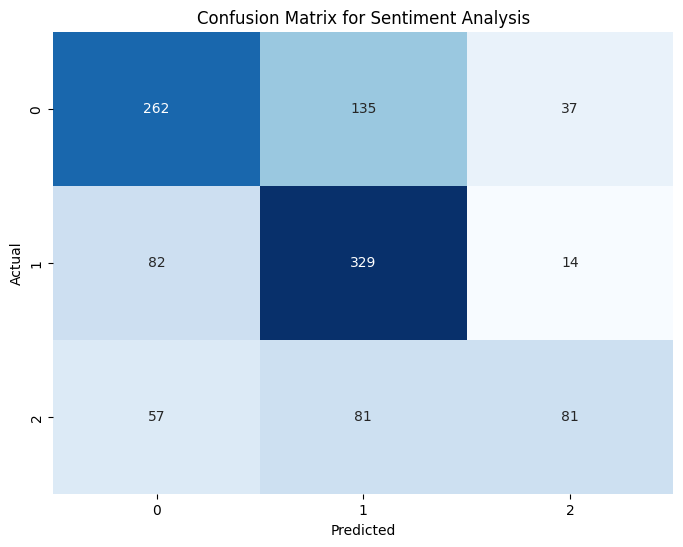

+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|text_clean                                                                                                                                 |sentiment_label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|Cruz  New Sheriff in town  Nice summary  He cherishes freedom   your freedom   GOPDebates                                                  |Positive       |0.0       |
|Santorum said he wants to make America the    manufacturing country  Manufacturing is   th century thinking  We need high tech   GOPDebates|Positive       |0.0       |
|I ve been using the wrong hashtag   GOPDebates  GOPDebate                                                                                  |Negative      

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

#Initializes a logistic regression model.
logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[label_indexer, vectorizer, logistic_regression])

# Train the Model
train_df, test_df = cleaned_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

# Make Predictions
predictions = model.transform(test_df)

# Calculate Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of the sentiment model: {accuracy:.2f}")

#Confusion Matrix
predictions_and_labels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictions_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

# Compare Actual vs. Predicted
predictions.select("text_clean", "sentiment_label", "prediction").show(10, truncate=False)

Root Mean Squared Error (RMSE): 0.7331581773635055
R² (Explained Variance): 0.07966124788395001


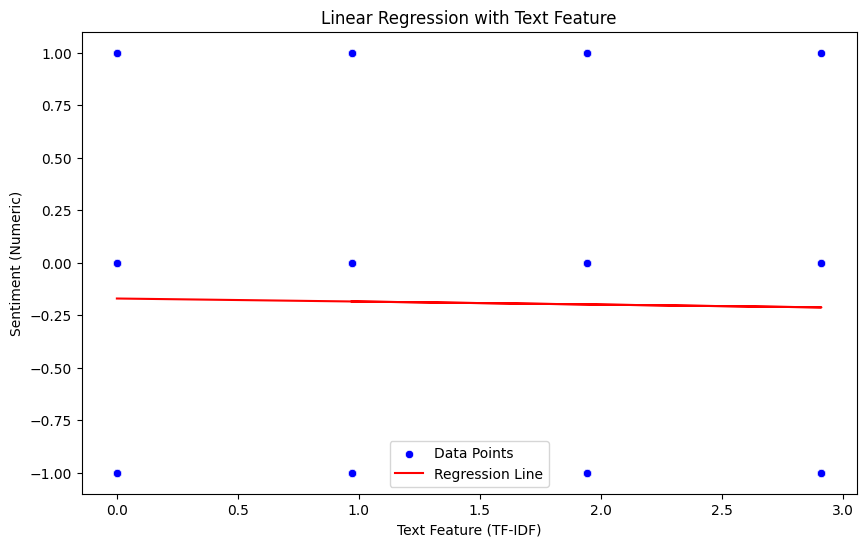

+-----+--------------------+--------------------+-----------+----------------------+---------+--------------------+--------------------+-------------------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------------------+--------------------+--------------------+
|   id|           candidate|candidate_confidence|relevant_yn|relevant_yn_confidence|sentiment|sentiment_confidence|      subject_matter|subject_matter_confidence|           name|retweet_count|                text|         tweet_coord|       tweet_created|            tweet_id|      tweet_location|       user_timezone|               words|      filtered_words|       text_no_emoji|        text_no_urls|          text_clean|sentiment_label|sentiment_numeric|         word_tokens| 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, countDistinct
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


if cleaned_df.count() == 0:
    raise ValueError("The DataFrame 'cleaned_df' is empty. Please check data preparation steps.")

# 'sentiment' to numeric
cleaned_df = cleaned_df.withColumn("sentiment_numeric",
                                   when(col("sentiment") == "Positive", 1)
                                   .when(col("sentiment") == "Neutral", 0)
                                   .when(col("sentiment") == "Negative", -1)
                                   .otherwise(None))

#  Tokenize 'text_clean' into a new column
tokenizer = Tokenizer(inputCol="text_clean", outputCol="word_tokens")  # Use a unique name
df_tokenized = tokenizer.transform(cleaned_df)

if df_tokenized.count() == 0:
    raise ValueError("Tokenized DataFrame is empty. Check the 'text_clean' column for valid content.")

# Converts the tokenized words into a feature vector using the HashingTF
hashing_tf = HashingTF(inputCol="word_tokens", outputCol="raw_features", numFeatures=100)
df_hashed = hashing_tf.transform(df_tokenized)

if df_hashed.count() == 0:
    raise ValueError("Hashed DataFrame is empty. Check 'word_tokens' content.")

# create feature vectors and IDF transformation to scale down the impact of common words and highlight more informative words.
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(df_hashed)  # This line could cause issues if `df_hashed` is empty
df_vectorized = idf_model.transform(df_hashed)

#Selects only the relevant columns for training model
df_prepared = df_vectorized.select("features", "sentiment_numeric")

lr = LinearRegression(featuresCol="features", labelCol="sentiment_numeric")
lr_model = lr.fit(df_prepared)

predictions = lr_model.transform(df_prepared)

evaluator_rmse = RegressionEvaluator(labelCol='sentiment_numeric', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='sentiment_numeric', predictionCol='prediction', metricName='r2')

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² (Explained Variance):", r2)

df_pandas = predictions.select("features", "sentiment_numeric", "prediction").toPandas()

feature_values = [v[0] for v in df_pandas["features"]]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature_values, y=df_pandas["sentiment_numeric"], color="blue", label="Data Points")

y_pred = [v * lr_model.coefficients[0] + lr_model.intercept for v in feature_values]
plt.plot(feature_values, y_pred, color="red", label="Regression Line")

plt.xlabel("Text Feature (TF-IDF)")
plt.ylabel("Sentiment (Numeric)")
plt.title("Linear Regression with Text Feature")

plt.legend()

plt.show()
df_vectorized.show()

*Interpretation:*
The blue points represent actual sentiment values against their corresponding features (TF-IDF).
The red line represents the predicted sentiment based on linear regression.
*Analysis:*
If the points are widely scattered and do not closely follow the regression line, it indicates that the model may not be effectively capturing the relationship between features and sentiment.

In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from pyspark.sql.types import StringType, ArrayType

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993222 sha256=c3a9d0890cb1026fedfa80c49b8dde91d4d0e2c498609ffc202e0e7bd400668f
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [ ]:
from langdetect import detect
print(detect("This is a test sentence."))

en


In [ ]:
from pyspark.sql.functions import col, when
from langdetect import detect

# Define the UDF for language detection
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

detect_lang_udf = udf(detect_language, StringType())

# Add a new column for language detection
cleaned_df = cleaned_df.withColumn("language", detect_lang_udf(col("text_clean")))

# Filter rows with languages other than English
non_english_df = cleaned_df.filter(col("language") != "en")

# Check if there are any non-English rows
if non_english_df.count() == 0:
    print("No other language detected.")
else:
    non_english_df.show(truncate=True)



+-----+--------------------+--------------------+-----------+----------------------+---------+--------------------+--------------------+-------------------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------+
|   id|           candidate|candidate_confidence|relevant_yn|relevant_yn_confidence|sentiment|sentiment_confidence|      subject_matter|subject_matter_confidence|           name|retweet_count|                text|         tweet_coord|       tweet_created|            tweet_id|      tweet_location|       user_timezone|               words|      filtered_words|       text_no_emoji|        text_no_urls|          text_clean|sentiment_label|sentiment_numeric|language|
+-----+--------------------+--------------------+-----------+-----

In [ ]:
# Selecting only the 'id' and 'language' columns
result_df = non_english_df.select("id", "language")

# Show the resulting DataFrame
result_df.show()


+-----+--------+
|   id|language|
+-----+--------+
| 7717|      it|
| 5395|      no|
| 7220|      id|
| 6775|      da|
|13052|      ca|
|11987|      lt|
|10122|      cy|
| 5332|      id|
| 5223|      fr|
| 7881|      nl|
| 3968|      de|
| 3120|      de|
| 3035|      de|
|  322|      fr|
|13687|      de|
|13532|      nl|
|13362|      en|
|13326|      et|
|13313|      fr|
|13104|      ca|
+-----+--------+
only showing top 20 rows



In [ ]:

#Inverse Document Frequency (IDF)
# R2 indicates how well the independent variables explain the variance in the dependent variable.
#RMSE gives an indication of prediction accuracy; lower values are better.


#Interpretation: RMSE measures the average magnitude of the errors between predicted and actual sentiment values.
# A lower RMSE value indicates better model performance, as it signifies that predictions are closer to the actual values.
#Context: In this case, an RMSE of approximately 0.73 suggests that, on average, the predictions deviate from the actual sentiment
#values by about 0.73 units on the numeric scale used for sentiment (where Positive = 1, Neutral = 0, Negative = -1).
#Interpretation: R² indicates how well the independent variables explain the variance in the dependent variable (sentiment).
#It ranges from 0 to 1, where a value closer to 1 means that a larger proportion of variance is explained by the model.
#Context: An R² value of approximately 0.08 suggests that only about 8% of the variance in sentiment can be explained by the
#features used in this model. This indicates that the model may not be capturing enough information from the data to make accurate predictions.